In [1]:
import numpy as np
import pandas as pd
from statistics import mean, variance
from tqdm import tqdm
from seldonian.RL.environments.Environment import *
from seldonian.RL.Env_Description.Env_Description import *

# generate_data.py
from seldonian.RL.RL_runner import run_trial
from seldonian.utils.io_utils import save_pickle,load_pickle

from seldonian.RL.Agents.Policies.Softmax import DiscreteSoftmax
from seldonian.RL.Env_Description.Env_Description import Env_Description
from seldonian.RL.Env_Description.Spaces import Discrete_Space
from seldonian.spec import createRLSpec
from seldonian.dataset import RLDataSet

from seldonian.seldonian_algorithm import SeldonianAlgorithm
# from seldonian.utils.io_utils import load_pickle
from seldonian.utils.plot_utils import plot_gradient_descent
import matplotlib.pyplot as plt

import autograd.numpy as np   # Thinly-wrapped version of Numpy

from experiments.generate_plots import RLPlotGenerator

from seldonian.utils.io_utils import load_pickle
from seldonian.utils.stats_utils import weighted_sum_gamma
from seldonian.RL.RL_runner import create_agent,run_trial_given_agent_and_env
import os




pip install gym


pip install simglucose



In [2]:
np.random.randint(2)

0

In [3]:
class Robinhood_Tutoring(Environment):
    def __init__(self, num_states,num_actions):
        """ Square gridworld RL environment of arbitrary size.
        
        :param size: The number of grid cells on a side 
        :ivar num_states: The number of distinct grid cells
        :ivar env_description: contains attributes describing the environment
        :vartype env_description: :py:class:`.Env_Description`
        :ivar obs: The current obs
        :vartype obs: int
        :ivar terminal_state: Whether the terminal obs is occupied
        :vartype terminal_state: bool
        :ivar time: The current timestep
        :vartype time: int
        :ivar max_time: Maximum allowed timestep
        :vartype max_time: int
        :ivar gamma: The discount factor in calculating the expected return
        :vartype gamma: float
        """
        # self.size = size
        self.num_states = num_states
        self.num_actions = num_actions
        self.env_description = self.create_env_description(self.num_states,self.num_actions)
        self.state = -1
        self.terminal_state = False
        self.time = 0
        self.max_time = 101
        # vis is a flag for visual debugging during obs transitions
        self.vis = False
        self.gamma = 0.9
        self.rews = [[[0.2729,0.1924,0.0358,0.0089,0.0157,0.0537,0.0492,0.0089,0.0179,0.0381,0.3065],
         [0.1751,0.1673,0.0350,0.0039,0.0039,0.0545,0.0233,0.0078,0.0117,0.0856,0.4319],
         [0.3523,0.2911,0.1350,0.0211,0.0148,0.0148,0.0084,0.0105,0.0105,0.0339,0.1076]],
        [[0.3077,0.1795,0.0531,0.0274,0.0201,0.0733,0.0989,0.0128,0.0092,0.0311,0.1869],
         [0.8601,0.1280,0.0089,0.0030],
         [0.4088,0.3205,0.1286,0.0191,0.0115,0.0115,0.0115,0.0058,0.0096,0.0116,0.0615]]]
        self.rew_list = [[[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10]],[[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,10],[0,1,2,3,4,5,6,7,8,9,10]]]

    def create_env_description(self, num_states, num_actions):
        """ Creates the environment description object.  
        :param num_states: The number of states
        :return: Environment description for the obs and action spaces
        :rtype: :py:class:`.Env_Description`
        """
        observation_space = Discrete_Space(0, num_states-1)
        action_space = Discrete_Space(0, num_actions-1)
        return Env_Description(observation_space, action_space)

    def reset(self):
        """ Go back to initial obs and timestep """
        self.state = np.random.randint(2)
        self.time = 0
        self.terminal_state = False

    def get_reward(self,st,action):
        return np.random.choice(self.rew_list[st][action],1,p=self.rews[st][action])[0]

    def transition(self, action):
        """ Transition between states given an action, return a reward. 
        
        :param action: A possible action at the current obs
        :return: reward for reaching the next obs
        """
        reward = 0
        self.time += 1
        # self.update_position(action)

        reward = self.get_reward(self.state,action)
        self.terminal_state  = True

        # if self.is_in_goal_state() or self.time >= self.max_time - 1:
        #     self.terminal_state = True
        #     if self.is_in_goal_state():
        #         reward = 1
        # if self.state == 7:
        #     reward = -1
        if self.vis:
            self.visualize()
            print("reward", reward)
        return reward

    def get_observation(self):
        """ Get the current obs """
        return self.state

    # def update_position(self, action):
    #     """ Helper function for transition() that updates the 
    #     current position given an action 
    #     :param action: A possible action at the current obs
    #     """
    #     if action == 0: #up
    #         if self.state >= self.size: #if not on top row
    #             self.state -= self.size
    #     elif action == 1: #right
    #         if (self.state + 1) % self.size != 0: #not on right column
    #             self.state += 1
    #     elif action == 2: #down
    #         if self.state < self.num_states - self.size: #not on bottom row
    #             self.state += self.size
    #     elif action == 3: #left
    #         if self.state % self.size != 0: #not on left column
    #             self.state -= 1
    #     else:
    #         raise Exception(f"invalid gridworld action {action}")

    # def is_in_goal_state(self):
    #     """ Check whether current obs is goal obs
    #     :return: True if obs is in goal obs, False if not
    #     """
    #     return self.state == self.num_states - 1

    def visualize(self):
        """ Print out current obs information
        """
        # print_state = 0
        # for y in range(self.size):
        #     for x in range(self.size):
        #         if print_state == self.state:
        #             print("A", end="")
        #         else:
        #             print("X", end="")
        #         print_state += 1
        #     print()
        # print()
        print("Gender: ",self.state)

In [4]:
def generate_episodes_and_calc_J(**kwargs):
        """ Calculate the expected discounted return 
        by generating episodes

        :return: episodes, J, where episodes is the list
            of generated ground truth episodes and J is
            the expected discounted return
        :rtype: (List(Episode),float)
        """
        # Get trained model weights from running the Seldonian algo
        model = kwargs['model']
        new_params = model.policy.get_params()
       
        # create env and agent
        hyperparameter_and_setting_dict = kwargs['hyperparameter_and_setting_dict']
        agent = create_agent(hyperparameter_and_setting_dict)
        env = Robinhood_Tutoring(2,3)
       
        # set agent's weights to the trained model weights
        agent.set_new_params(new_params)
        
        # generate episodes
        num_episodes = kwargs['n_episodes_for_eval']
        episodes = run_trial_given_agent_and_env(
            agent=agent,env=env,num_episodes=num_episodes)

        # Calculate J, the discounted sum of rewards
        returns = np.array([weighted_sum_gamma(ep.rewards,env.gamma) for ep in episodes])
        J = np.mean(returns)
        return episodes,J
# perf_eval_kwargs = {'n_episodes_for_eval':n_episodes_for_eval}   

In [12]:
trial_dict = {}
trial_dict["env"] = Robinhood_Tutoring(2,3)
trial_dict["agent"] = "Parameterized_non_learning_softmax_agent"
trial_dict["num_episodes"] = 10000
trial_dict["num_trials"] = 1
trial_dict["vis"] = False

# def main():/
episodes, agent = run_trial(trial_dict)
for ep in episodes:
    print(ep)
episodes_file = './robinhood_tutoring_1000episodes.pkl'
save_pickle(episodes_file,episodes)

Have 10000 episodes in trial
return = 0
1 observations, type of first in array is <class 'numpy.int64'>: [1]
1 actions, type of first in array is <class 'numpy.int64'>: [1]
1 rewards, type of first in array is <class 'numpy.int64'>: [0]
1 action_probs, type of first in array is <class 'numpy.float64'>: [0.33333333]
return = 0
1 observations, type of first in array is <class 'numpy.int64'>: [0]
1 actions, type of first in array is <class 'numpy.int64'>: [2]
1 rewards, type of first in array is <class 'numpy.int64'>: [0]
1 action_probs, type of first in array is <class 'numpy.float64'>: [0.33333333]
return = 1
1 observations, type of first in array is <class 'numpy.int64'>: [0]
1 actions, type of first in array is <class 'numpy.int64'>: [2]
1 rewards, type of first in array is <class 'numpy.int64'>: [1]
1 action_probs, type of first in array is <class 'numpy.float64'>: [0.33333333]
return = 0
1 observations, type of first in array is <class 'numpy.int64'>: [1]
1 actions, type of first in

In [13]:
episodes_file = './robinhood_tutoring_1000episodes.pkl'
episodes_eval = load_pickle(episodes_file)
rewards = [ep.rewards for ep in episodes_eval]
print(np.mean(rewards))

3.0794


In [6]:
episodes_file = './robinhood_tutoring_1000episodes.pkl'
episodes = load_pickle(episodes_file)
dataset = RLDataSet(episodes=episodes)


# Initialize policy
# num_states = 9
observation_space = Discrete_Space(0, 1)
action_space = Discrete_Space(0, 2)
env_description =  Env_Description(observation_space, action_space)
policy = DiscreteSoftmax(hyperparam_and_setting_dict={},
    env_description=env_description)
env_kwargs={'gamma':1}
save_dir = '.'
constraint_strs = ['J_pi_new >= 4']
deltas=[0.05]

spec = createRLSpec(
    dataset=dataset,
    policy=policy,
    constraint_strs=constraint_strs,
    deltas=deltas,
    env_kwargs=env_kwargs,
    save=True,
    save_dir='.',
    verbose=True)

Saved ./spec.pkl



In [11]:
# load specfile
specfile = './spec.pkl'
spec = load_pickle(specfile)
spec.optimization_hyperparams['num_iters']=100
spec.optimization_hyperparams['alpha_theta']=0.05
spec.optimization_hyperparams['alpha_lamb']=0.01
# Run Seldonian algorithm 
SA = SeldonianAlgorithm(spec)
passed_safety,solution = SA.run(write_cs_logfile=True)
if passed_safety:
    print("Passed safety test!")
    print("The solution found is:")
    print(solution)
else:
    print("No Solution Found")
print("Primary objective (-IS estimate) evaluated on safety dataset:")
print(SA.evaluate_primary_objective(branch='safety_test',theta=solution))

Safety dataset has 6000 episodes
Candidate dataset has 4000 episodes
Have 100 epochs and 1 batches of size 4000

Epoch: 0, batch iteration 0
Epoch: 1, batch iteration 0
Epoch: 2, batch iteration 0
Epoch: 3, batch iteration 0
Epoch: 4, batch iteration 0
Epoch: 5, batch iteration 0
Epoch: 6, batch iteration 0
Epoch: 7, batch iteration 0
Epoch: 8, batch iteration 0
Epoch: 9, batch iteration 0
Epoch: 10, batch iteration 0
Epoch: 11, batch iteration 0
Epoch: 12, batch iteration 0
Epoch: 13, batch iteration 0
Epoch: 14, batch iteration 0
Epoch: 15, batch iteration 0
Epoch: 16, batch iteration 0
Epoch: 17, batch iteration 0
Epoch: 18, batch iteration 0
Epoch: 19, batch iteration 0
Epoch: 20, batch iteration 0
Epoch: 21, batch iteration 0
Epoch: 22, batch iteration 0
Epoch: 23, batch iteration 0
Epoch: 24, batch iteration 0
Epoch: 25, batch iteration 0
Epoch: 26, batch iteration 0
Epoch: 27, batch iteration 0
Epoch: 28, batch iteration 0
Epoch: 29, batch iteration 0
Epoch: 30, batch iteration 

In [13]:
cs_file = './log_grad_descent/candidate_selection_log0_4_100.p'
solution_dict = load_pickle(cs_file)
solution_dict

{'candidate_solution': array([[ 1.70388683,  1.73667657, -1.73023736],
        [ 1.74503981, -1.73900034, -1.80362092]]),
 'best_index': array(99),
 'best_g': array([-0.02846742]),
 'best_f': array(-4.33817654),
 'found_feasible_solution': True,
 'theta_vals': [array([[0., 0., 0.],
         [0., 0., 0.]]),
  array([[ 0.04999949,  0.04999987, -0.0499999 ],
         [ 0.04999989, -0.04999988, -0.0499986 ]]),
  array([[ 0.13159601,  0.13215382, -0.13204533],
         [ 0.13231991, -0.13220563, -0.13338848]]),
  array([[ 0.23791601,  0.23979231, -0.23942693],
         [ 0.24034132, -0.23996295, -0.24389779]]),
  array([[ 0.36111455,  0.36496111, -0.36421104],
         [ 0.36606859, -0.365303  , -0.37331285]]),
  array([[ 0.49322759,  0.49948057, -0.49825968],
         [ 0.50125395, -0.50002324, -0.5129679 ]]),
  array([[ 0.6271684 ,  0.63604791, -0.63431229],
         [ 0.63853153, -0.63680064, -0.65508196]]),
  array([[ 0.75731817,  0.76886757, -0.76660808],
         [ 0.77205812, -0.7698

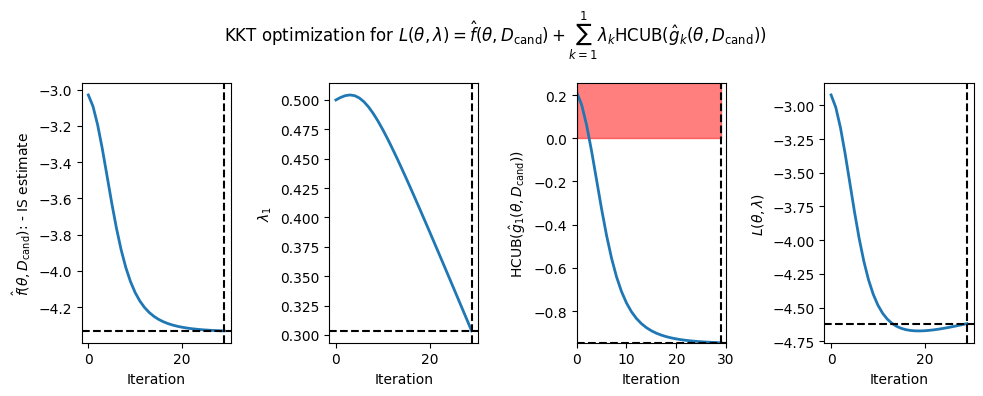

In [6]:
cs_file = './log_grad_descent/candidate_selection_log0.p'
solution_dict = load_pickle(cs_file)

fig = plot_gradient_descent(solution_dict,
    primary_objective_name='- IS estimate',
    save=False)
plt.show()

Running experiment
generating new episodes for each trial
Trial: 0
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial0.pkl already created
Trial: 1
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial1.pkl already created
Trial: 2
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial2.pkl already created
Trial: 3
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial3.pkl already created
Trial: 4
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial4.pkl already created
Trial: 5
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial5.pkl already created
Trial: 6
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial6.pkl already created
Trial: 7
results/gridworld_2022Dec09_4_20_trials/regenerated_datasets/regenerated_data_trial7.pkl already created
Trial: 8
results/gridworld_202

  0%|          | 0/200 [00:00<?, ?it/s]


Trial 16 already run for this data_frac: 0.005011872336272725. Skipping this trial. 
Trial 17 already run for this data_frac: 0.005011872336272725. Skipping this trial. 
Trial 18 already run for this data_frac: 0.005011872336272725. Skipping this trial. 
Trial 19 already run for this data_frac: 0.005011872336272725. Skipping this trial. 
Trial 0 already run for this data_frac: 0.009027251779484578. Skipping this trial. 

 11%|█         | 22/200 [00:00<00:01, 91.11it/s]


Trial 1 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 2 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 3 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 4 already run for this data_frac: 0.009027251779484578. Skipping this trial. Trial 5 already run for this data_frac: 0.009027251779484578. Skipping this trial. 

Trial 6 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 7 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 8 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 9 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 10 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 11 already run for this data_frac: 0.009027251779484578. Skipping this trial. 


 16%|█▌        | 32/200 [00:00<00:05, 28.76it/s]

Trial 12 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 13 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 14 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 15 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 16 already run for this data_frac: 0.009027251779484578. Skipping this trial. 


 18%|█▊        | 37/200 [00:01<00:07, 21.55it/s]

Trial 17 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 18 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 19 already run for this data_frac: 0.009027251779484578. Skipping this trial. 
Trial 0 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 20%|██        | 41/200 [00:01<00:08, 19.12it/s]

Trial 1 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 2 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 3 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 22%|██▏       | 44/200 [00:01<00:08, 17.62it/s]

Trial 4 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 5 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 23%|██▎       | 46/200 [00:02<00:09, 16.83it/s]

Trial 6 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 7 already run for this data_frac: 0.01625964693881482. Skipping this trial. 

 24%|██▍       | 48/200 [00:02<00:09, 16.05it/s]


Trial 8 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 9 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 25%|██▌       | 50/200 [00:02<00:09, 15.36it/s]

Trial 10 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 11 already run for this data_frac: 0.01625964693881482. Skipping this trial. 

 26%|██▌       | 52/200 [00:02<00:10, 14.78it/s]


Trial 12 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 13 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 27%|██▋       | 54/200 [00:02<00:10, 14.31it/s]

Trial 14 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 15 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 28%|██▊       | 56/200 [00:02<00:10, 14.00it/s]

Trial 16 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 17 already run for this data_frac: 0.01625964693881482. Skipping this trial. 


 29%|██▉       | 58/200 [00:02<00:10, 13.77it/s]

Trial 18 already run for this data_frac: 0.01625964693881482. Skipping this trial. 
Trial 19 already run for this data_frac: 0.01625964693881482. Skipping this trial. 

 30%|███       | 60/200 [00:03<00:10, 13.60it/s]

 31%|███       | 62/200 [00:03<00:10, 13.51it/s]

Trial 0 already run for this data_frac: 0.029286445646252372. Skipping this trial. 


 32%|███▏      | 64/200 [00:03<00:11, 12.18it/s]

Trial 1 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 2 already run for this data_frac: 0.029286445646252372. Skipping this trial. 


 33%|███▎      | 66/200 [00:03<00:10, 12.47it/s]

Trial 3 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 4 already run for this data_frac: 0.029286445646252372. Skipping this trial. 

 34%|███▍      | 68/200 [00:03<00:10, 12.68it/s]


Trial 5 already run for this data_frac: 0.029286445646252372. Skipping this trial. 

 35%|███▌      | 70/200 [00:03<00:10, 12.88it/s]


Trial 6 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 7 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 8 already run for this data_frac: 0.029286445646252372. Skipping this trial. 


 36%|███▌      | 72/200 [00:04<00:09, 12.87it/s]

Trial 9 already run for this data_frac: 0.029286445646252372. Skipping this trial. 


 37%|███▋      | 74/200 [00:04<00:09, 12.97it/s]

Trial 10 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 11 already run for this data_frac: 0.029286445646252372. Skipping this trial. 


 38%|███▊      | 76/200 [00:04<00:09, 13.01it/s]

Trial 12 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 13 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 14 already run for this data_frac: 0.029286445646252372. Skipping this trial. 

 39%|███▉      | 78/200 [00:04<00:09, 13.04it/s]


Trial 15 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 16 already run for this data_frac: 0.029286445646252372. Skipping this trial. 


 40%|████      | 80/200 [00:04<00:09, 13.05it/s]

Trial 17 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 18 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 19 already run for this data_frac: 0.029286445646252372. Skipping this trial. 
Trial 0 already run for this data_frac: 0.052749970637026196. Skipping this trial. 

 41%|████      | 82/200 [00:04<00:09, 13.09it/s]


Trial 1 already run for this data_frac: 0.052749970637026196. Skipping this trial. 

 42%|████▏     | 84/200 [00:05<00:08, 13.07it/s]


Trial 2 already run for this data_frac: 0.052749970637026196. Skipping this trial. 


 43%|████▎     | 86/200 [00:05<00:08, 13.13it/s]

Trial 3 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 4 already run for this data_frac: 0.052749970637026196. Skipping this trial. 


 44%|████▍     | 88/200 [00:05<00:09, 11.93it/s]

Trial 5 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 6 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 7 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 8 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 9 already run for this data_frac: 0.052749970637026196. Skipping this trial. 

 45%|████▌     | 90/200 [00:05<00:10, 10.50it/s]


Trial 10 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 11 already run for this data_frac: 0.052749970637026196. Skipping this trial. 

 46%|████▋     | 93/200 [00:05<00:08, 12.83it/s]


Trial 12 already run for this data_frac: 0.052749970637026196. Skipping this trial. 



 48%|████▊     | 95/200 [00:05<00:08, 12.80it/s]

Trial 14 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 13 already run for this data_frac: 0.052749970637026196. Skipping this trial. Trial 15 already run for this data_frac: 0.052749970637026196. Skipping this trial. 


 48%|████▊     | 97/200 [00:06<00:09, 11.13it/s]

Trial 16 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 17 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 18 already run for this data_frac: 0.052749970637026196. Skipping this trial. 
Trial 19 already run for this data_frac: 0.052749970637026196. Skipping this trial. 


 50%|█████     | 100/200 [00:06<00:09, 10.56it/s]


Trial 1 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 52%|█████▏    | 103/200 [00:06<00:07, 12.63it/s]



Trial 4 already run for this data_frac: 0.0950118507318144. Skipping this trial. 
Trial 3 already run for this data_frac: 0.0950118507318144. Skipping this trial. 



 53%|█████▎    | 106/200 [00:06<00:06, 14.39it/s]

Trial 5 already run for this data_frac: 0.0950118507318144. Skipping this trial. Trial 0 already run for this data_frac: 0.0950118507318144. Skipping this trial. Trial 2 already run for this data_frac: 0.0950118507318144. Skipping this trial. Trial 6 already run for this data_frac: 0.0950118507318144. Skipping this trial. 


 54%|█████▍    | 108/200 [00:06<00:06, 14.09it/s]

Trial 7 already run for this data_frac: 0.0950118507318144. Skipping this trial. 
Trial 8 already run for this data_frac: 0.0950118507318144. Skipping this trial. 
Trial 9 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 55%|█████▌    | 110/200 [00:07<00:06, 13.81it/s]



Trial 10 already run for this data_frac: 0.0950118507318144. Skipping this trial. Trial 11 already run for this data_frac: 0.0950118507318144. Skipping this trial. 


 56%|█████▌    | 112/200 [00:07<00:07, 12.44it/s]

Trial 12 already run for this data_frac: 0.0950118507318144. Skipping this trial. 
Trial 13 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 57%|█████▋    | 114/200 [00:07<00:06, 12.59it/s]


Trial 14 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 58%|█████▊    | 116/200 [00:07<00:06, 12.86it/s]


Trial 15 already run for this data_frac: 0.0950118507318144. Skipping this trial. 
Trial 16 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 59%|█████▉    | 118/200 [00:07<00:06, 12.97it/s]


Trial 17 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 60%|██████    | 120/200 [00:07<00:06, 12.92it/s]


Trial 18 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 61%|██████    | 122/200 [00:08<00:05, 13.06it/s]


Trial 19 already run for this data_frac: 0.0950118507318144. Skipping this trial. 

 62%|██████▏   | 124/200 [00:08<00:05, 13.09it/s]


Trial 0 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 1 already run for this data_frac: 0.1711328304161781. Skipping this trial. 

 63%|██████▎   | 126/200 [00:08<00:05, 13.12it/s]


Trial 2 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 3 already run for this data_frac: 0.1711328304161781. Skipping this trial. 


 64%|██████▍   | 128/200 [00:08<00:05, 13.12it/s]

Trial 4 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 5 already run for this data_frac: 0.1711328304161781. Skipping this trial. 

 65%|██████▌   | 130/200 [00:08<00:05, 13.07it/s]


Trial 6 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 7 already run for this data_frac: 0.1711328304161781. Skipping this trial. 

 66%|██████▌   | 132/200 [00:08<00:05, 13.09it/s]


Trial 8 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 9 already run for this data_frac: 0.1711328304161781. Skipping this trial. 

 67%|██████▋   | 134/200 [00:08<00:05, 13.11it/s]


Trial 10 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 11 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 12 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 13 already run for this data_frac: 0.1711328304161781. Skipping this trial. 

 68%|██████▊   | 136/200 [00:09<00:04, 13.06it/s]


Trial 14 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 15 already run for this data_frac: 0.1711328304161781. Skipping this trial. 

 69%|██████▉   | 138/200 [00:09<00:05, 11.89it/s]


Trial 16 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 17 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 18 already run for this data_frac: 0.1711328304161781. Skipping this trial. 
Trial 19 already run for this data_frac: 0.1711328304161781. Skipping this trial. 


 70%|███████   | 140/200 [00:09<00:04, 12.16it/s]

Trial 0 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 1 already run for this data_frac: 0.30823992397451433. Skipping this trial. 

 71%|███████   | 142/200 [00:09<00:04, 12.40it/s]


Trial 2 already run for this data_frac: 0.30823992397451433. Skipping this trial. 

 72%|███████▏  | 144/200 [00:09<00:04, 12.67it/s]


Trial 3 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 4 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 5 already run for this data_frac: 0.30823992397451433. Skipping this trial. 

 73%|███████▎  | 146/200 [00:09<00:04, 12.79it/s]


Trial 6 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 7 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 8 already run for this data_frac: 0.30823992397451433. Skipping this trial. 

 74%|███████▍  | 148/200 [00:10<00:04, 12.86it/s]


Trial 9 already run for this data_frac: 0.30823992397451433. Skipping this trial. 


 75%|███████▌  | 150/200 [00:10<00:03, 12.90it/s]

Trial 10 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 11 already run for this data_frac: 0.30823992397451433. Skipping this trial. 


 76%|███████▌  | 152/200 [00:10<00:03, 12.90it/s]

Trial 12 already run for this data_frac: 0.30823992397451433. Skipping this trial. 


 77%|███████▋  | 154/200 [00:10<00:03, 13.00it/s]

Trial 13 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 14 already run for this data_frac: 0.30823992397451433. Skipping this trial. 

 78%|███████▊  | 156/200 [00:10<00:03, 13.01it/s]


Trial 15 already run for this data_frac: 0.30823992397451433. Skipping this trial. 


 79%|███████▉  | 158/200 [00:10<00:03, 13.00it/s]

Trial 16 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 17 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 18 already run for this data_frac: 0.30823992397451433. Skipping this trial. 

 80%|████████  | 160/200 [00:11<00:03, 13.00it/s]


Trial 19 already run for this data_frac: 0.30823992397451433. Skipping this trial. 
Trial 0 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 81%|████████  | 162/200 [00:11<00:03, 11.90it/s]


Trial 1 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 2 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 82%|████████▏ | 164/200 [00:11<00:02, 12.10it/s]


Trial 3 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 83%|████████▎ | 166/200 [00:11<00:02, 12.45it/s]


Trial 4 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 5 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 6 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 84%|████████▍ | 168/200 [00:11<00:02, 10.79it/s]


Trial 7 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 8 already run for this data_frac: 0.5551935914386209. Skipping this trial. 


 85%|████████▌ | 170/200 [00:11<00:02, 11.26it/s]

Trial 9 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 10 already run for this data_frac: 0.5551935914386209. Skipping this trial. 


 86%|████████▌ | 172/200 [00:12<00:02, 11.52it/s]

Trial 11 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 12 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 13 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 87%|████████▋ | 174/200 [00:12<00:02, 11.82it/s]


Trial 14 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 15 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 88%|████████▊ | 177/200 [00:12<00:01, 14.03it/s]


Trial 16 already run for this data_frac: 0.5551935914386209. Skipping this trial. 


 90%|████████▉ | 179/200 [00:12<00:01, 13.79it/s]

Trial 17 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 18 already run for this data_frac: 0.5551935914386209. Skipping this trial. 
Trial 19 already run for this data_frac: 0.5551935914386209. Skipping this trial. 

 90%|█████████ | 181/200 [00:12<00:01, 13.59it/s]


Trial 0 already run for this data_frac: 1.0. Skipping this trial. 
Trial 1 already run for this data_frac: 1.0. Skipping this trial. 
Trial 2 already run for this data_frac: 1.0. Skipping this trial. 


 92%|█████████▏| 183/200 [00:12<00:01, 13.40it/s]

Trial 3 already run for this data_frac: 1.0. Skipping this trial. 
Trial 4 already run for this data_frac: 1.0. Skipping this trial. 


 92%|█████████▎| 185/200 [00:13<00:01, 13.32it/s]

Trial 5 already run for this data_frac: 1.0. Skipping this trial. 
Trial 6 already run for this data_frac: 1.0. Skipping this trial. 


 94%|█████████▎| 187/200 [00:13<00:00, 13.21it/s]

Trial 7 already run for this data_frac: 1.0. Skipping this trial. 
Trial 8 already run for this data_frac: 1.0. Skipping this trial. 


 94%|█████████▍| 189/200 [00:13<00:00, 12.04it/s]


Trial 9 already run for this data_frac: 1.0. Skipping this trial. Trial 10 already run for this data_frac: 1.0. Skipping this trial. 

 96%|█████████▌| 191/200 [00:13<00:00, 12.37it/s]


Trial 11 already run for this data_frac: 1.0. Skipping this trial. 
Trial 12 already run for this data_frac: 1.0. Skipping this trial. 


 96%|█████████▋| 193/200 [00:13<00:00, 12.61it/s]

Trial 13 already run for this data_frac: 1.0. Skipping this trial. 
Trial 14 already run for this data_frac: 1.0. Skipping this trial. 


 98%|█████████▊| 195/200 [00:13<00:00, 12.75it/s]


Trial 15 already run for this data_frac: 1.0. Skipping this trial. Trial 16 already run for this data_frac: 1.0. Skipping this trial. 


 98%|█████████▊| 197/200 [00:13<00:00, 12.84it/s]

Trial 17 already run for this data_frac: 1.0. Skipping this trial. 
Trial 18 already run for this data_frac: 1.0. Skipping this trial. 


100%|█████████▉| 199/200 [00:14<00:00, 12.87it/s]

Trial 19 already run for this data_frac: 1.0. Skipping this trial. 


100%|██████████| 200/200 [00:14<00:00, 14.12it/s]


Saved results/gridworld_2022Dec09_4_20_trials/qsa_results/qsa_results.csv


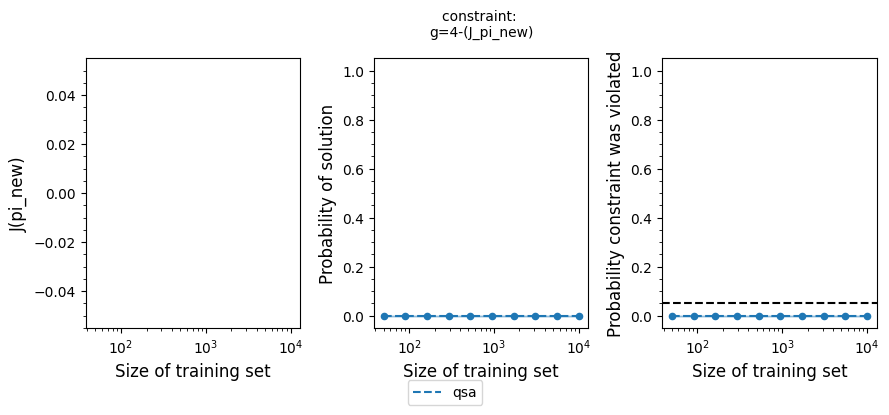

In [5]:
# Parameter setup
run_experiments = True
make_plots = True
save_plot = False
performance_metric = 'J(pi_new)'
n_trials = 20
data_fracs = np.logspace(-2.3,0,10)
# print(data_fracs)

n_workers = 8
verbose=True
results_dir = f'results/gridworld_2022Dec09_4_{n_trials}_trials'
os.makedirs(results_dir,exist_ok=True)
plot_savename = os.path.join(results_dir,f'gridworld_{n_trials}trials.png')
n_episodes_for_eval = 1000
# Load spec
specfile = f'./spec.pkl'
spec = load_pickle(specfile)
spec.optimization_hyperparams['num_iters'] = 40
spec.optimization_hyperparams['alpha_theta'] = 0.01
spec.optimization_hyperparams['alpha_lamb'] = 0.01
spec.optimization_hyperparams['beta_velocity'] = 0.9
spec.optimization_hyperparams['beta_rmspropr'] = 0.95

perf_eval_fn = generate_episodes_and_calc_J
perf_eval_kwargs = {'n_episodes_for_eval':n_episodes_for_eval}

hyperparameter_and_setting_dict = {}
hyperparameter_and_setting_dict["env"] = Robinhood_Tutoring(2,3)
hyperparameter_and_setting_dict["agent"] = "Parameterized_non_learning_softmax_agent"
hyperparameter_and_setting_dict["num_episodes"] = 5000
hyperparameter_and_setting_dict["num_trials"] = 1
hyperparameter_and_setting_dict["vis"] = False

plot_generator = RLPlotGenerator(
    spec=spec,
    n_trials=n_trials,
    data_fracs=data_fracs,
    n_workers=n_workers,
    datagen_method='generate_episodes',
    hyperparameter_and_setting_dict=hyperparameter_and_setting_dict,
    perf_eval_fn=perf_eval_fn,
    perf_eval_kwargs=perf_eval_kwargs,
    results_dir=results_dir,
    )
if run_experiments:
    plot_generator.run_seldonian_experiment(verbose=verbose)

if make_plots:
    if save_plot:
        plot_generator.make_plots(fontsize=12,legend_fontsize=8,
            performance_label=performance_metric,
            savename=plot_savename)
    else:
        plot_generator.make_plots(fontsize=12,legend_fontsize=8,
            performance_label=performance_metric,)

In [71]:
np.ones(4)

array([1., 1., 1., 1.])

In [72]:
dataframe_data_old = pd.read_csv('../../Python/datasets/mturk/mturk_old.csv')
dataframe_data = pd.read_csv('../../Python/datasets/mturk/mturk.csv')
dataframe_data_old

,gender,tutorial,quizScore
0,0,1,0
1,1,1,10
2,1,1,0
3,0,1,0
4,0,1,10
...,...,...,...
1791,1,3,2
1792,0,3,7
1793,1,3,2
1794,0,3,4


In [73]:
dataframe_data

,gender,tutorial,quizScore
0,0,1,0
1,1,1,10
2,1,1,0
3,0,1,0
4,0,1,10
...,...,...,...
2591,1,3,1
2592,1,3,1
2593,1,3,0
2594,0,3,0


In [74]:
dataframe_data["tutorial"].value_counts()

1    999
3    998
2    599
Name: tutorial, dtype: int64

### Exploratory Data Analysis

In [75]:
dataframe_data["gender"].value_counts()

 1    1403
 0    1178
-9      15
Name: gender, dtype: int64

In [76]:
dataframe_data_male = dataframe_data[dataframe_data.gender == 0]
dataframe_data_female = dataframe_data[dataframe_data.gender == 1]
dataframe_data_male

,gender,tutorial,quizScore
0,0,1,0
3,0,1,0
4,0,1,10
5,0,1,8
7,0,1,1
...,...,...,...
2587,0,3,10
2588,0,3,0
2589,0,3,4
2594,0,3,0


In [77]:
dataframe_data_female

,gender,tutorial,quizScore
1,1,1,10
2,1,1,0
6,1,1,0
8,1,1,0
11,1,1,0
...,...,...,...
2586,1,3,0
2590,1,3,0
2591,1,3,1
2592,1,3,1


In [78]:
dataframe_data_male["tutorial"].value_counts()

3    474
1    447
2    257
Name: tutorial, dtype: int64

In [79]:
dataframe_data_female["tutorial"].value_counts()

1    546
3    521
2    336
Name: tutorial, dtype: int64

- Here for males, the distribution of tutorials is given as follows
    - tutorial three is selected with 474/1178 = 0.4023
    - tutorial one is selected with 447/1178 = 0.3795
    - tutorial two is selected with 257/1178 = 0.2182
    
- Here for females, the distribution of tutorials is given as follows
    - tutorial three is selected with 521/1403 = 0.3713
    - tutorial one is selected with 546/1403 =  0.3892
    - tutorial two is selected with 336/1403 =  0.2395


In [80]:
dataframe_data_male_1 = dataframe_data_male[dataframe_data_male.tutorial == 1]
dataframe_data_male_2 = dataframe_data_male[dataframe_data_male.tutorial == 2]
dataframe_data_male_3 = dataframe_data_male[dataframe_data_male.tutorial == 3]
dataframe_data_female_1 = dataframe_data_female[dataframe_data_female.tutorial == 1]
dataframe_data_female_2 = dataframe_data_female[dataframe_data_female.tutorial == 2]
dataframe_data_female_3 = dataframe_data_female[dataframe_data_female.tutorial == 3]
# dataframe_data_male_1 = dataframe_data[dataframe_data.gender == 0 and dataframe_data.tutorial == 2]
# dataframe_data_male_2 = dataframe_data[dataframe_data.gender == 0 and dataframe_data.tutorial == 3]
# dataframe_data_female_0 = dataframe_data[dataframe_data.gender == 1 and dataframe_data.tutorial == 1]
# dataframe_data_female_1 = dataframe_data[dataframe_data.gender == 1 and dataframe_data.tutorial == 2]
# dataframe_data_female_2 = dataframe_data[dataframe_data.gender == 1 and dataframe_data.tutorial == 3]

In [81]:
dataframe_data_male_1

,gender,tutorial,quizScore
0,0,1,0
3,0,1,0
4,0,1,10
5,0,1,8
7,0,1,1
...,...,...,...
992,0,1,10
993,0,1,10
994,0,1,0
996,0,1,0


In [82]:
dataframe_data_male_1["quizScore"].value_counts()

10    137
0     122
1      86
5      24
6      22
9      17
2      16
8       8
4       7
7       4
3       4
Name: quizScore, dtype: int64

<AxesSubplot:>

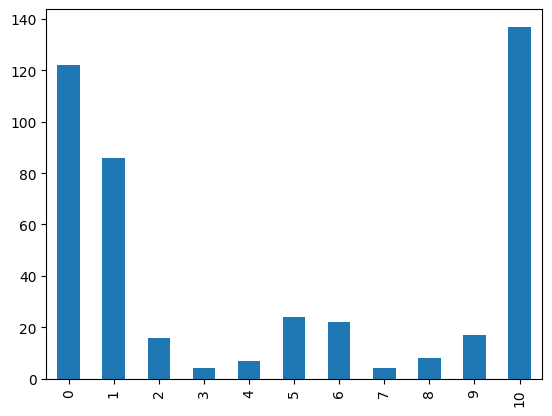

In [116]:
dataframe_data_male_1["quizScore"].value_counts().sort_index().plot.bar()

In [83]:
sum = 137+122+86+24+22+17+16
print(122.0/sum,86/sum,16/sum,24/sum,22/sum,17/sum,137.0/sum)

0.28773584905660377 0.2028301886792453 0.03773584905660377 0.05660377358490566 0.05188679245283019 0.04009433962264151 0.3231132075471698


In [84]:
dataframe_data_male_2["quizScore"].value_counts()

10    111
0      45
1      43
9      22
5      14
2       9
6       6
8       3
7       2
4       1
3       1
Name: quizScore, dtype: int64

<AxesSubplot:>

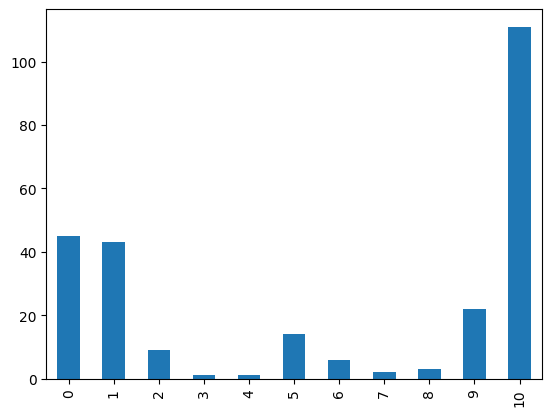

In [117]:
dataframe_data_male_2["quizScore"].value_counts().sort_index().plot.bar()

In [85]:
sum = 111+45+43+22+14
print(str(45/sum)+","+str(43/sum)+","+str(14/sum)+","+str(22/sum)+","+str(111/sum))

0.19148936170212766,0.1829787234042553,0.059574468085106386,0.09361702127659574,0.4723404255319149


In [86]:
dataframe_data_male_3["quizScore"].value_counts()

0     167
1     138
2      64
10     51
9      16
3      10
5       7
4       7
7       5
8       5
6       4
Name: quizScore, dtype: int64

<AxesSubplot:>

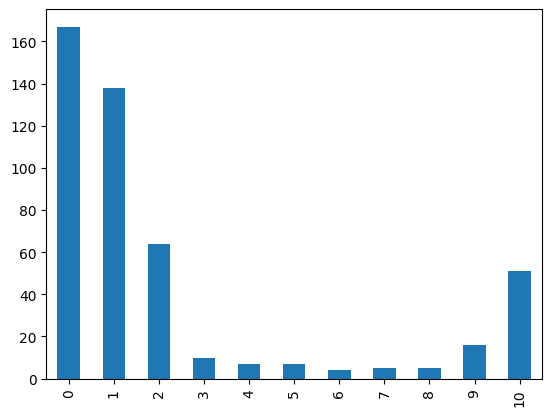

In [118]:
dataframe_data_male_3["quizScore"].value_counts().sort_index().plot.bar()

In [87]:
sum = 167+138+64+51+16+10
print(str(167/sum)+","+str(138/sum)+","+str(64/sum)+","+str(10/sum)+","+str(16/sum)+","+str(51/sum))

0.3744394618834081,0.3094170403587444,0.14349775784753363,0.02242152466367713,0.03587443946188341,0.11434977578475336


In [88]:
dataframe_data_female_1["quizScore"].value_counts()

0     168
10    102
1      98
6      54
5      40
2      29
9      17
3      15
4      11
7       7
8       5
Name: quizScore, dtype: int64

In [89]:
sum = 168+102+98+54+40+29+17+15+11
print(str(168/sum)+","+str(98/sum)+","+str(29/sum)+","+str(15/sum)+","+str(11/sum)+","+str(40/sum)+","+str(54/sum)+","+str(17/sum)+","+str(102/sum))

0.3146067415730337,0.18352059925093633,0.054307116104868915,0.028089887640449437,0.020599250936329586,0.0749063670411985,0.10112359550561797,0.031835205992509365,0.19101123595505617


<AxesSubplot:>

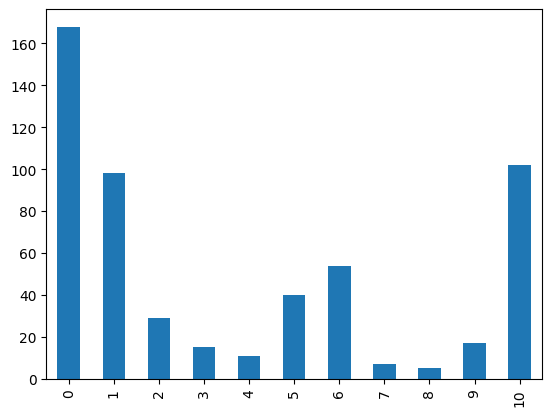

In [119]:
dataframe_data_female_1["quizScore"].value_counts().sort_index().plot.bar()

In [90]:
dataframe_data_female_2["quizScore"].value_counts()

0     289
1      43
2       3
10      1
Name: quizScore, dtype: int64

<AxesSubplot:>

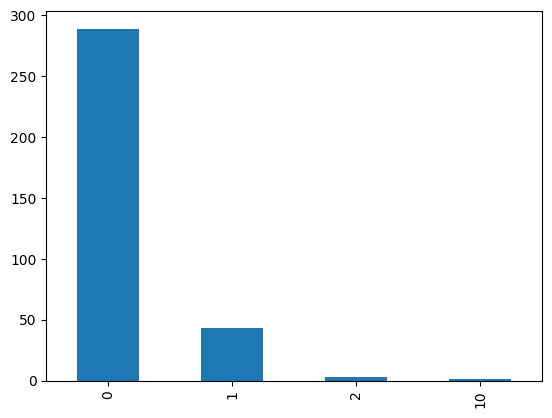

In [120]:
dataframe_data_female_2["quizScore"].value_counts().sort_index().plot.bar()

In [91]:
dataframe_data_female_3["quizScore"].value_counts()

0     213
1     167
2      67
10     32
3      10
5       6
6       6
4       6
9       6
8       5
7       3
Name: quizScore, dtype: int64

<AxesSubplot:>

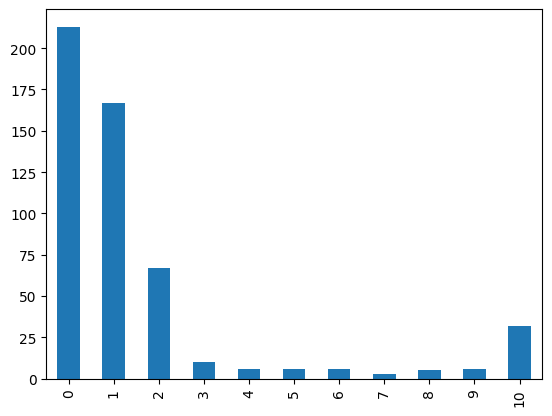

In [121]:
dataframe_data_female_3["quizScore"].value_counts().sort_index().plot.bar()

In [92]:
sum = 213+167+67+32+10
print(str(213/sum)+","+str(167/sum)+","+str(67/sum)+","+str(10/sum)+","+str(32/sum))

0.43558282208588955,0.34151329243353784,0.13701431492842536,0.02044989775051125,0.065439672801636


In [93]:
def argmax(lst):
  return lst.index(max(lst))

In [94]:
rews = [[[0.2729,0.1924,0.0358,0.0089,0.0157,0.0537,0.0492,0.0089,0.0179,0.0381,0.3065],
         [0.1751,0.1673,0.0350,0.0039,0.0039,0.0545,0.0233,0.0078,0.0117,0.0856,0.4319],
         [0.3523,0.2911,0.1350,0.0211,0.0148,0.0148,0.0084,0.0105,0.0105,0.0339,0.1076]],
        [[0.3077,0.1795,0.0531,0.0274,0.0201,0.0733,0.0989,0.0128,0.0092,0.0311,0.1869],
         [0.8601,0.1280,0.0089,0.0030],
         [0.4088,0.3205,0.1286,0.0191,0.0115,0.0115,0.0115,0.0058,0.0096,0.0116,0.0615]]]
rew_list = [[[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10]],[[0,1,2,3,4,5,6,7,8,9,10],[0.0,1.0,2.0,10.0],[0,1,2,3,4,5,6,7,8,9,10]]]
def rew(state,act):
    return np.random.choice(rew_list[state][act],1,p=rews[state][act])[0]

In [95]:
x = [0.4088,0.3205,0.1286,0.0191,0.0115,0.0115,0.0115,0.0058,0.0096,0.0116,0.0615]
print(type(x))
s = 0
for i in x:
    s += i
print(s)

<class 'list'>
1.0


In [97]:
# np.random.choice([0,1,2,10],11,[0.8601,0.1280,0.0089,0.0030])/
# rew(1,2)
# print(np.random.choice(rew_list[1][1],11111111,rews[1][1]))
print(rew_list[1][1],rews[1][1],mean(np.random.choice(rew_list[1][1],111111,p=rews[1][1])))
mean(np.random.choice(rew_list[1][1],111111,p=[0.25,0.25,0.15,0.35]))

[0.0, 1.0, 2.0, 10.0] [0.8601, 0.128, 0.0089, 0.003] 0.1757161757161757


4.056016056016056

In [98]:
mean([ 6,  2,  3,  6,  6, 10,  4,  2,  2,  6,  4])

4.636363636363637

### Using random selection of actions

In [99]:
genders = [0,1]

tutorials = [0,1,2]



def monte_carlo_exploring_starts(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1)[0]
        init_act = np.random.choice(len(tutorials),1)[0]
        
        # print(init_state,init_act)
        rtns[init_state][init_act].append(rew(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [100]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:57<00:00, 239.28it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.4824780232834405, 5.924794785127958, 2.3490222276205515], [3.7232681848066465, 0.17966388586627977, 1.6637005398350833]]


In [101]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:54<00:00, 241.38it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.4969204090175205, 5.901648219441771, 2.3410646157572823], [3.697423748889547, 0.17691755414622473, 1.6503234387280092]]


In [102]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:54<00:00, 241.27it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.531107374489551, 5.896949071586364, 2.3722768692293768], [3.7139418737589507, 0.1765656807567956, 1.6199796492488179]]


### Using selection of actions from the whole dataset D_0

In [103]:
genders = [0,1]
tutorials = [0,1,2]
gender_probs = [(1403.0/1403.0+1178.0),(1178.0/1403.0+1178.0)]
tutorial_probs_male = [0.3795,0.2182,0.4023]
tutorial_probs_female = [0.3892,0.2395,0.3713]

def monte_carlo_exploring_starts(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1,gender_probs)[0]
        if init_state == 0:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_male)[0]
        else:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_female)[0]
        
        
        rtns[init_state][init_act].append(rew(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [104]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:54<00:00, 241.52it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.4859476339178475, 5.8850375850137215, 2.3797253976894694], [3.683967358694348, 0.17683328344806945, 1.6752187987051912]]


In [105]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:56<00:00, 239.94it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.554778972520908, 5.842496285289747, 2.3418271843487712], [3.767258501354198, 0.17099227426364075, 1.6592175423881133]]


In [106]:
monte_carlo_exploring_starts(100000)

  8%|▊         | 7779/100000 [00:02<00:33, 2766.30it/s] 


KeyboardInterrupt: 

### Using only the tailscores


In [107]:
rews = [[[0.28773584905660377,0.2028301886792453,0.03773584905660377,0.05660377358490566,0.05188679245283019,0.04009433962264151,0.3231132075471698],
         [0.19148936170212766,0.1829787234042553,0.059574468085106386,0.09361702127659574,0.4723404255319149],
         [0.3744394618834081,0.3094170403587444,0.14349775784753363,0.02242152466367713,0.03587443946188341,0.11434977578475336]],
        [[0.3146067415730337,0.18352059925093633,0.054307116104868915,0.028089887640449437,0.020599250936329586,0.0749063670411985,0.10112359550561797,0.031835205992509365,0.19101123595505617],
         [0.8601,0.1280,0.0089,0.0030],
         [0.43558282208588955,0.34151329243353784,0.13701431492842536,0.02044989775051125,0.065439672801636]]]
rew_list = [[[0,1,2,5,6,9,10],[0,1,5,9,10],[0,1,2,3,9,10]],[[0,1,2,3,4,5,6,9,10],[0,1,2,10],[0,1,2,3,10]]]
def rew_a(state,act):
    return np.random.choice(rew_list[state][act],1,p=rews[state][act])[0]

In [108]:
x = [0.19148936170212766,0.1829787234042553,0.059574468085106386,0.09361702127659574,0.4723404255319149]
s = 0
for i in x:
    s += i
s

1.0

### Using random actions

In [109]:
genders = [0,1]

tutorials = [0,1,2]



def monte_carlo_exploring_starts_tailends(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1)[0]
        init_act = np.random.choice(len(tutorials),1)[0]
        
        
        rtns[init_state][init_act].append(rew_a(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [110]:
monte_carlo_exploring_starts_tailends(100000)

100%|██████████| 100000/100000 [06:52<00:00, 242.54it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.417684945524589, 5.992253647991353, 2.1064861951248726], [3.668638346179124, 0.17691800922321374, 1.32403782448955]]


In [ ]:
monte_carlo_exploring_starts_tailends(100000)

100%|██████████| 100000/100000 [06:49<00:00, 244.49it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.7233140194731495, 4.995678790061217, 4.16664656212304], [4.436963263358779, 3.3081454764051696, 3.2296256169495607]]


In [ ]:
monte_carlo_exploring_starts_tailends(100000)

100%|██████████| 100000/100000 [06:50<00:00, 243.32it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.7337842734629785, 5.028698100772871, 4.173310328415041], [4.416063279586249, 3.2369671060444127, 3.166026641065643]]


### Using actual state and policy probabilities (excluding middle scores)

In [111]:
genders = [0,1]
tutorials = [0,1,2]
gender_probs = [(1403.0/1403.0+1178.0),(1178.0/1403.0+1178.0)]
tutorial_probs_male = [0.3795,0.2182,0.4023]
tutorial_probs_female = [0.3892,0.2395,0.3713]

def monte_carlo_exploring_starts_tailend_actual(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1,gender_probs)[0]
        if init_state == 0:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_male)[0]
        else:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_female)[0]
        
        
        rtns[init_state][init_act].append(rew_a(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [112]:
monte_carlo_exploring_starts_tailend_actual(100000)

100%|██████████| 100000/100000 [06:52<00:00, 242.43it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.435223522352235, 5.973509933774834, 2.157344328911199], [3.640894607106355, 0.17721897025444988, 1.3169836302359172]]


In [ ]:
monte_carlo_exploring_starts_tailend_actual(100000)

100%|██████████| 100000/100000 [06:49<00:00, 244.07it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.750178359096314, 5.0122181022430246, 4.202898550724638], [4.465078309245933, 3.235213857744557, 3.190829642044774]]


In [ ]:
monte_carlo_exploring_starts_tailend_actual(100000)

100%|██████████| 100000/100000 [06:51<00:00, 242.73it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.72998002542219, 5.020049519898545, 4.184292333861223], [4.472870090634441, 3.2403937947494033, 3.1989010325463436]]
